1. Version  : 1
2. Time     : 5th May
3. Author   : Hui Zhang
4. Function : PBCD method to solve 2 hidden layer 0/1 DNN on MNIST
5. Structure: 2 hidden layer with 1000 nodes in each layer
6. Relation paper: PBCD method for 0/1 DNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive


# **Define relavant function and load data**

In [ ]:
import numpy as np   # science calculate  instill numpy
import struct  # y???????
from sklearn.utils import shuffle  # instill scikit-learn/ scikit
import time
import os  # o??????????
import scipy
import torch as tc
import tensorflow as tf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
import tensorflow.keras as keras
from tensorflow.keras import datasets
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,Activation,BatchNormalization,AveragePooling2D,MaxPooling2D
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Standardized data in 0-1
def normalize_data(ima):
    a_max = np.max(ima)  # 图像矩阵的最大值
    a_min = np.min(ima)  # 图像矩阵的最小值
    for i in range(ima.shape[0]):  # 矩阵第二维的长度：如3*4矩阵这个就是3
        for j in range(ima.shape[1]):  # numpy.core.fromnumeric 中的函数 第一维的长度
            ima[i][j] = (ima[i][j] - a_min) / (a_max - a_min)
    return ima  # 返回是一个矩阵

# predeal dataset
def create_model(directory):
    # chanDim = -1
    input_shape = (28, 28, 1)
    model_original = load_model(os.path.join(directory, "prenetwork/99.4_CNN.h5"))

    model = Sequential()
    # Layer 1 Conv2D
    cnn_layer = Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = input_shape)
    cnn_layer.trainable=False
    model.add(cnn_layer)
    cnn_layer2= Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False)
    cnn_layer2.trainable=False
    model.add(cnn_layer2)
    cnn_layer3=BatchNormalization()
    cnn_layer3.trainable=False
    model.add(cnn_layer3)
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = 2, strides = 2))
    model.add(Dropout(0.25,name = 'representation')) ############## 需要这一层的输出
    # Layer 3 Conv2D
    cnn_layer4= Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu')
    cnn_layer4.trainable=False
    model.add(cnn_layer4)
    cnn_layer5= Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False)
    cnn_layer5.trainable=False
    model.add(cnn_layer5)
    cnn_layer6= BatchNormalization()
    cnn_layer6.trainable=False
    model.add(cnn_layer6)
    # Layer 4 Pooling Layer
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = 2, strides = 2))
    model.add(Dropout(0.25))
    model.add(Flatten(name='flatten'))


    model.add(Dense(500, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(300, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(100, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(20, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    model.layers[0].set_weights(model_original.layers[0].get_weights())
    model.layers[1].set_weights(model_original.layers[1].get_weights())
    model.layers[2].set_weights(model_original.layers[2].get_weights())
    model.layers[6].set_weights(model_original.layers[6].get_weights())
    model.layers[7].set_weights(model_original.layers[7].get_weights())
    model.layers[8].set_weights(model_original.layers[8].get_weights())
    return model


# 初始化各个参数 n_x x的维数 n_h1：第一隐层节点数（靠近x的）, n_h2：第二隐层节点数, n_y： 输出y的维数
def initialize_with_zeros(n_x, n_h1, n_h2, n_y):

    W1 = tf.random.uniform([n_x, n_h1], minval = -np.sqrt(6) / np.sqrt(n_x + n_h1), maxval = np.sqrt(6) / np.sqrt(n_h1 + n_x), dtype=tf.dtypes.float32, seed=None, name=None)
    W2 = tf.random.uniform([n_h1, n_h2], minval = -np.sqrt(6) / np.sqrt(n_h1 + n_h2), maxval = np.sqrt(6) / np.sqrt(n_h1 + n_h2), dtype=tf.dtypes.float32, seed=None, name=None)
    W3 = tf.random.uniform([n_h2, n_y], minval = -np.sqrt(6) / np.sqrt(n_y + n_h2), maxval = np.sqrt(6) / np.sqrt(n_y + n_h2), dtype=tf.dtypes.float32, seed=None, name=None)
    dW1_1 = tf.zeros((n_x, n_h1))
    dW1_2 = tf.zeros((n_x, n_h1))
    dW2_1 = tf.zeros((n_h1, n_h2))
    dW2_2 = tf.zeros((n_h1, n_h2))
    dW3_1 = tf.zeros((n_h2, n_y))
    dW3_2 = tf.zeros((n_h2, n_y))

    g_sum = {"dW1_1": dW1_1,
             "dW1_2": dW1_2,
             "dW2_1": dW2_1,
             "dW2_2": dW2_2,
             "dW3_1": dW3_1,
             "dW3_2": dW3_2
             }
    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3,
                  "idx1": np.nonzero(tf.ones((n_x, 1)) )[0],
                  "idx2": np.nonzero(tf.ones((n_h1, 1)) )[0],  # initial
                  "idx3": np.nonzero(tf.ones((n_h2, 1)) )[0]  # initial
                  }
    pa_in = 1.e-7 * np.ones((4, 1))  # 每一层罚参数初始值
    pa_in[3] = 1 / (2 * batch_size)  # 每一层罚参数初始值
    tau_in = 1.e-6 * np.ones((4, 1))  # 每一层罚参数初始值
    return parameters, pa_in, tau_in, g_sum


# 存储参数
def save_parameters(parameters, directory):
    for key, val in parameters.items():
        if not os.path.exists(os.path.join(directory, str(key) + '.npy')):
          os.makedirs(os.path.join(directory, str(key) + '.npy'))
        tf.save(os.path.join(directory, str(key) + '.npy'), val)


def costloss(V3, Y):
    cost = tf.square(tf.norm(V3 - Y)) / 2
    return cost

def penaltyloss(P, C, X, Y):
    cost1 = pa[0] * tf.square( tf.norm(Y - hardmax(C["U3"])) )
    cost2 = tau[3] * tf.square(tf.norm( C["U3"] - tf.matmul(tf.transpose(P['W3']),  C["V2"]))  )
    cost3 = pa[2] * tf.square( tf.norm(C["V2"] - sgn(C["U2"])) ) + tau[2] * tf.square( tf.norm(C["U2"] - tf.matmul(tf.transpose(P['W2']), C["V1"])) )
    cost4 =  pa[1] * tf.square( tf.norm(C["V1"] - sgn(C["U1"])) ) + tau[1] * tf.square( tf.norm(C["U1"] - tf.matmul(tf.transpose(P['W1']), X)) )
    cost5 = gam * (tf.square( tf.norm(P['W3'])) + tf.square(tf.norm(P['W2'])) + tf.square(tf.norm(P['W1'])))

    cost = {"cost1": cost1.numpy(),
             "cost2": cost2.numpy(),
             "cost3": cost3.numpy(),
             "cost4": cost4.numpy(),
             "cost5": cost5.numpy(),
             "costall": cost1.numpy() + cost2.numpy() + cost3.numpy()+cost4.numpy()+cost5.numpy()
             }
    return cost

def sgn(x):
    s = tf.sign(x * tf.cast(x > 0, dtype=tf.float32))
    return s


def softmax(x):  # 返回第一个最大值的位置
    v = tf.argmax(x)
    return v

def hardmax(x):  # 返回矩阵值 dimision: 10 * 64
    v1 = np.zeros(x.shape)
    v = np.argmax(x, 0)  # tf.argmax(a,1) 每一列最大值位置
    for i in range(x.shape[1]):
        v1[v[i], i] = 1

    return tf.convert_to_tensor(v1, dtype=tf.float32)

# 将原矩阵拉成784列但不知道多少行（-1）的矩阵（np.会自动计算配套维数）
def image2vector(image):
    v = np.reshape(image, [-1, n_x])
    return v.T


def mini_batchs_generator(inputs, targets, batch_size):
    inputs_data_size = len(inputs)
    targets_data_size = len(targets)
    # print("len(inputs):={}, size of inputs {}, size of targets{}".format(inputs_data_size, inputs.shape, targets.shape))
    assert inputs_data_size == targets_data_size, "The length of inputs({}) and targets({}) must be consistent".format(
        inputs_data_size, targets_data_size)

    shuffled_input, shuffled_target = shuffle(inputs, targets)  # 元素随机排序？
    mini_batches = [(shuffled_input[k: k + batch_size], shuffled_target[k: k + batch_size])
                    for k in range(0, inputs_data_size, batch_size)]  #
    for x, y in mini_batches:
        # print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        # print(x.shape)
        yield x, y  # yield = return的功能 + 未终止再使用直到循环完毕(实现一个epoch功能)

def produce_step_adam(grad_1, grad_2, g_new, epsilon, delta, rho_1, rho_2, step_ad):
    """
    adam
     (i) 梯度滑动-一阶矩  g = rho_1 * grad_1 + (1-rho_1)*g_new
     (ii)二阶矩  r_t = rho_2 * grad + (1-rho_1)*g_new*g_new
     (iii)更新  step = epsilon /sqrt(delta+r_t)
    """
    grad_1 = rho_1 * grad_1 + (1 - rho_1) * g_new
    g = grad_1 / (1 - pow(rho_1, step_ad))
    r_t = rho_2 * grad_2 + (1 - rho_2) * g_new * g_new
    r = r_t / (1 - pow(rho_2, step_ad))
    step = epsilon / tf.sqrt(delta + r)
    return step, g, grad_1, r_t

def forward_propagation_pre(x_tol, parameters_for):
    layers_num = 3
    cache_for = {}
    layer_input = x_tol
    for layer in range(1, layers_num + 1):
        locals()['A' + str(layer)] = tf.matmul(tf.transpose(parameters_for['W' + str(layer)]),
                                            layer_input)
        cache_for['A' + str(layer)] = locals()['A' + str(layer)]
        locals()['Z' + str(layer)] = locals()['A' + str(layer)] * tf.cast(locals()['A' + str(layer)] > 0, dtype=tf.float32)
        layer_input = locals()['Z' + str(layer)]
        cache_for['Z' + str(layer)] = locals()['Z' + str(layer)]
    return locals()['Z' + str(layers_num)], cache_for

def prox_l0(x, sparse, vec_yn):
    k = int(x.shape[0] * sp0)
    abx = np.linalg.norm(x, axis=1, keepdims=True)
    # print(abx.shape, x.shape[0], k)
    thre = np.partition(abx, kth=k, axis=None)[k]
    abx *= (abx >= thre)
    # print(np.partition(x, kth=k, axis=None)[k], np.sqrt(2 * 0.13 * sparse * lr))
    # x *= x >= np.sqrt(2 * sparse * lr)
    # if k > 5:
    #     thre = np.partition(x, kth=k, axis=None)[k]
    #     x *= (x >= thre)
    return abx

def optimizer_adam(parameters, cache, X, Y, g_sum, epsilon, delta, rho_1, rho_2, step_ad, iht=False):
    A1 = cache["Z1"]
    A2 = cache["Z2"]
    A3 = cache["Z3"]


    dZ3 = (A3 - Y)  # * Z3(1-Z3)  # h2 * batch
    dZ2 = tf.matmul(parameters["W3"], dZ3) * tf.cast(A2 > 0,dtype=tf.float32)
    dZ1 = tf.matmul(parameters["W2"], dZ2) * tf.cast(A1 > 0,dtype=tf.float32)

    dW3 = tf.matmul((A2), tf.transpose(dZ3))
    dW2 = tf.matmul((A1), tf.transpose(dZ2))
    dW1 = tf.matmul((X), tf.transpose(dZ1))

    step_W3, dW3, g_sum["dW3_1"], g_sum["dW3_2"] = produce_step_adam(g_sum["dW3_1"], g_sum["dW3_2"], dW3,
                                                                     epsilon, delta, rho_1, rho_2, step_ad)
    step_W2, dW2, g_sum["dW2_1"], g_sum["dW2_2"] = produce_step_adam(g_sum["dW2_1"], g_sum["dW2_2"], dW2,
                                                                     epsilon, delta, rho_1, rho_2, step_ad)
    step_W1, dW1, g_sum["dW1_1"], g_sum["dW1_2"] = produce_step_adam(g_sum["dW1_1"], g_sum["dW1_2"], dW1, epsilon,
                                                                     delta, rho_1, rho_2, step_ad)
    parameters["W1"] -=  step_W1 * dW1
    ep = 1
    if ep > -10:
      parameters["W3"] -=  step_W3 * dW3
      parameters["W2"] -=  step_W2 * dW2
    else:
      sp0_pre = 0.7
      w3 = parameters["W3"].numpy()
      w2 = parameters["W2"].numpy()
      ep3 = 0 * w3
      ep2 = 0 * w2

      W_norm2 = prox_l0(w3, sp0_pre, vec_yn=0)
      idx_T = np.nonzero(W_norm2)[0]  # W行模的非0指标集Tk
      ep3[idx_T] = w3[idx_T] - step_W3.numpy()[idx_T] * dW3.numpy()[idx_T]

      W_norm2 = prox_l0(w2, sp0_pre, vec_yn=0)
      idx_T = np.nonzero(W_norm2)[0]  # W行模的非0指标集Tk
      ep2[idx_T] = w2[idx_T] - step_W2.numpy()[idx_T] * dW2.numpy()[idx_T]
      parameters["W2"] = tf.convert_to_tensor(w2, dtype = tf.float32)
      parameters["W3"] = tf.convert_to_tensor(w3, dtype = tf.float32)

    return parameters, g_sum


# feed forward
def forward_propagation(X, parameters):
    W1 = parameters["W1"]  # W1 维数 （784, 1000）
    W2 = parameters["W2"]
    W3 = parameters["W3"]

    U1 = tf.matmul(tf.transpose(W1), X)  # + b1 * parameters['gamma1']
    # betch_size =16, nx*nx = 784 X为（784，16）, gamma1为nx*nx，X * gamma1的维数和X维数相同
    V1 = sgn(U1)  # 实现Relu，V1为 (1000，16)为第1隐层的值
    U2 = tf.matmul(tf.transpose(W2), V1)  # + b2    # W2^T 维数 （1000,1000） * parameters['gamma2']
    V2 = sgn(U2)  # 实现Relu，V2 (1000，16)为第2隐层的值
    U3 = tf.matmul(tf.transpose(W3), V2)  # + b3    # W3^T为 （10，1000） * parameters['gamma3']
    V3 = hardmax(U3)  # 输出 维数是10*batch 大小

    cache = {
        "V0": X,
        "U0": X,
        "U1": U1,
        "V1": V1,
        "U2": U2,
        "V2": V2,
        "U3": U3,
        "V3": V3}

    return V3, cache




def save_parameters(parameters, directoryin):
    for key, val in parameters.items():
        np.save(os.path.join(directoryin, str(key)+'.npy'), val)

def load_parameters(directoryin):
    W1 = np.load(os.path.join(directoryin, 'W1.npy'))
    W2 = np.load(os.path.join(directoryin, 'W2.npy'))
    W3 = np.load(os.path.join(directoryin, 'W3.npy'))
    parameters = {"idx1": np.nonzero(np.ones((W1.shape[0], 1)))[0],
                  "idx2": np.nonzero(np.ones((W2.shape[0], 1)))[0],
                  "idx3": np.nonzero(np.ones((W3.shape[0], 1)))[0],
                  "W1": tf.convert_to_tensor(W1, dtype=tf.float32),
                  "W2": tf.convert_to_tensor(W2, dtype=tf.float32),
                  "W3": tf.convert_to_tensor(W3, dtype=tf.float32)
                  }
    return parameters


if __name__ == '__main__':
    data_name = "MNIST01"
    path_dict = {1: "01_BCD"}
    directory = ("/content/drive/MyDrive/PBCDcode/MNIST/data/")
    if not os.path.exists(directory):
        os.makedirs(directory)


# Predeal datas

In [ ]:
    # (train_images_or, train_labels), (test_images_or, test_labels) = tf.keras.datasets.mnist.load_data()

    # # How to train
    # # y_train = to_categorical(y_train)
    # # y_test = to_categorical(y_test)
    # model_CNN = create_model(directory)
    # # history = model_CNN.fit(x_train, y_train, batch_size=16, epochs=3, validation_split=0.05)
    # # # model specific
    # # model_CNN.summary()
    # # # How to evaluate
    # # loss, acc = model_CNN.evaluate(x_test, y_test, verbose=2)
    # # How to feadforward and predict
    # # x_test_select = x_test
    # # y_true = y_test
    # # y_pred = model_CNN.predict(x_test_select)
    # # print('predict result: ', y_pred.shape)
    # # print('true result: ', y_true.shape)
    # layer_name = 'flatten'
    # intermediate_layer_model = keras.Model(inputs=model_CNN.input,
    #                                       outputs=model_CNN.get_layer(layer_name).output)
    # train_images = intermediate_layer_model(train_images_or[0:60000,:,:])
    # test_images = intermediate_layer_model(test_images_or)
    # train_images = train_images.numpy()
    # test_images = test_images.numpy()
    # np.save(os.path.join(directory, "rawdata/train_images.npy"), train_images)
    # np.save(os.path.join(directory, "rawdata/test_images.npy"), test_images)
    # np.save(os.path.join(directory, "rawdata/train_labels.npy"), train_labels)
    # np.save(os.path.join(directory, "rawdata/test_labels.npy"), test_labels)

# Load dataset#

In [ ]:
# (train_images_or, train_labels), (test_images_or, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = np.load(os.path.join(directory, "rawdata/train_images.npy"))
test_images = np.load(os.path.join(directory, "rawdata/test_images.npy"))
train_labels = np.load(os.path.join(directory, "rawdata/train_labels.npy"))
test_labels = np.load(os.path.join(directory, "rawdata/test_labels.npy"))
# normal parameters
if 1:
    print(train_images.shape)
    n_x = train_images.shape[1]  # 764--> 578
    n_h1 = 2000  # 第一隐层
    n_h2 = 2000  # 第二隐层
    n_y = 10  # 输出层
    # adam parameters
    epsilon = 1.e-3  # adam步长的分子
    delta = 1.e-8  # adam步长的第一个分母
    rho_1 = 0.9  # adam 一阶距滑动系数
    rho_2 = 0.99  # adam 二阶距滑动系数
    step_ad = 10  # adam 二次下降


(60000, 576)


# Load PreTraining data #

In [ ]:
batch_size = len(train_labels)
trainall = normalize_data(train_images.T)
testall = normalize_data(test_images.T)

label_train = train_labels.T
label_train = tf.convert_to_tensor(label_train, dtype=tf.float32)
trainall = tf.convert_to_tensor(trainall, dtype=tf.float32)  # batch_size * feat nums  -->  feat nums * batch_size

label_test = test_labels.T
label_test = tf.convert_to_tensor(label_test, dtype=tf.float32)
testall = tf.convert_to_tensor(testall, dtype=tf.float32)       # batch_size * feat nums  -->  feat nums * batch_size


In [ ]:
def optimizer(parameters, pinter, X, Y, epoc):
    def tenf(koa):
        koa = tf.convert_to_tensor(koa, dtype = tf.float32)
        return koa
    def subuout(ain, biin, tau_in):
        # ain batchsize * 10, bin too Cheaked at January 26th
        uf = biin
        row, column = np.nonzero(ain)
        biin = biin.numpy()
        cin = tf.transpose(tf.ones((10, batch_size)) * tf.convert_to_tensor(biin[row, column], dtype = tf.float32))
        uin2 = tf.minimum(biin, cin)
        condition1 = tf.sqrt(tf.convert_to_tensor(tau_in, dtype = tf.float32)) * tf.linalg.norm(biin - uin2, ord=2, axis=1)  # axis 1 represents row
        T1 = (condition1 < 2)
        uf = uf.numpy()
        uf[T1,:] = uin2.numpy()[T1,:]
        # uf = uin2
        return tf.convert_to_tensor(uf.T, dtype = tf.float32)  # tf.transpose(uf)  #


    def subuin(ain, biin, tau_in):
        epi = 3.e-7
        uin = biin.numpy()
        condition1 = (biin > 0) & (ain < 0.5) & (ain < (1 - tau_in * biin * biin) / 2)
        condition2 = (biin < 0) & (ain > 0.5) & (ain > (1 + tau_in * biin * biin) / 2)
        uin[condition1] = 0
        uin[condition2] = epi
        return tf.convert_to_tensor(uin, dtype = tf.float32)

    def subw(win, bin, ain, tau_in, gam_in, epoc, layer):
        # Win.shape n_{layer-1}, n_layer
        # A.shape n_{layer-1}, N
        # B.shape n_{layer}, N
        b = 2 * tau_in * tf.matmul(ain, tf.transpose(bin))
        A = 2 * tau_in * tf.matmul(ain, tf.transpose(ain)) + gam_in * tf.eye(len(b))
        d_W = tf.matmul(A, win) - b  # * gamma~~~~~~~~~~~~
        W_try = win - lr * d_W
        if layer >1:
          if epoc < 200:
            W_norm2 = prox_l0(W_try, sp0, vec_yn=0)
            idx_T = np.nonzero(W_norm2)[0]  # W行模的非0指标集Tk
            win = win.numpy()
            win[idx_T] = W_try.numpy()[idx_T]
            if epoc > 5:
              idx_Tbar = np.argwhere(W_norm2 == 0)[:, 0]
              win[idx_Tbar] = 0
          else:
            W_norm2 = prox_l0(W_try, sp0, vec_yn=0)
            idx_T = np.nonzero(W_norm2)[0]  # W行模的非0指标集Tk
            idx_Tbar = np.argwhere(W_norm2 == 0)[:, 0]
            win = win.numpy()
            ain = ain.numpy()
            b2 =  2 * tau_in * tf.matmul(tf.matmul(ain[idx_T], tf.transpose(ain[idx_Tbar])), win[idx_Tbar])
            b = tenf(b.numpy()[idx_T]) - b2
          if epoc > 200:
            if epoc < 150:
              win[idx_Tbar] -= 1.e-2 * win[idx_Tbar]
            else:
              win[idx_Tbar] = 0
            A1 = tf.linalg.inv(2 * tau_in * tf.matmul(tenf(ain[idx_T]), tenf(tf.transpose(ain[idx_T]))) + gam_in * tf.eye(len(idx_T)))
            win[idx_T] = tf.matmul(A1, b)
        else:
          if epoc % 12 > -10:
            win = W_try
          else:
            win = tf.matmul(tf.linalg.inv(A), b)
          idx_T = np.nonzero(tf.ones((win.shape[0], 1)))[0]
        return tf.convert_to_tensor(win, dtype = tf.float32), idx_T  # tf.convert_to_tensor(, dtype = tf.float32)

    def subv(vin, idx, ain, bin, cin, pa_in, tau_in):  # 显示解
        # print(len(idx), vin.shape)
        # vin: 1000x64;  ain:  1000[idx+1]x10;  bin:  10, 64;   cin: 1000[idx+1], 64,
        for j in range(1):
            b = 2 * tau_in * tf.matmul(ain, bin) + 2 * pa_in * cin
            # vin -= lr * (2 * tau_in * tf.matmul(tf.matmul(ain, tf.transpose(ain)), vin) - b)
            A1 = tf.linalg.inv(2 * tau_in * tf.matmul(ain, tf.transpose(ain)) + 2 * pa_in * tf.eye(len(b)))
            # vin = vin.numpy()
            vin = tf.matmul(A1, b)
        return vin  # tf.convert_to_tensor(vin, dtype = tf.float32)

    for layer in range(3, 0, -1):
        if layer == 3:
            # Y 10*64;  W3 (1000, 10); V3 (10, 64);
            pinter['U' + str(layer)] = \
                subuout(tf.transpose(Y), tf.transpose(tf.matmul(tf.transpose(parameters["W" + str(layer)]), pinter['V' + str(layer - 1)])), tau[layer] * pa[layer])
            for ko in range(1):
              parameters['W' + str(layer)], parameters["idx" + str(layer)] = \
                  subw(parameters['W' + str(layer)], pinter['U' + str(layer)], pinter['V' + str(layer - 1)], tau[layer], gam, epoc, layer)
        else:
            pinter['V' + str(layer)] = subv(pinter['V' + str(layer)], parameters["idx" + str(layer + 1)],
                                            parameters["W" + str(layer + 1)], pinter['U' + str(layer + 1)],
                                            sgn(pinter['U' + str(layer)]), pa[layer], tau[layer+1])  # , parameters["idx" + str(layer + 1)])
            for ko in range(1):
              parameters['W' + str(layer)], parameters["idx" + str(layer)] = \
                  subw(parameters['W' + str(layer)], pinter['U' + str(layer)], pinter['V' + str(layer - 1)], tau[layer], gam, epoc, layer)
            pinter['U' + str(layer)] = subuin(pinter['V' + str(layer)],
                                              tf.matmul(tf.transpose(parameters["W" + str(layer)]), pinter['V' + str(layer - 1)]),
                                              tau[layer] / pa[layer])
    return parameters, pinter

# **3 Train 0/1 DNN by PBCD**

In [ ]:
batch_size = len(train_labels)
batch_size_pre = 128
# sp0_pre = 1 - 0.7
# time_all = [27.27 25.86 24.24  23.97   23.52 23.17   22.82   22.79 22.34 22.27]
# acc_all = [9923 9925 9926 9927 9931  9932  9929  9934  9921 9874]
sp0 = 1 - 0.9
lr = 0.72  # 6.e-2 ~ 6.e-1  turned at Feb 17th
ship = 2.e-2  # slippage for the next step
gam = 1.e-8  # turned at Feb 27th 6.e-2  --->  6.e-3   gamma for penalty norm2 "W"
best_acc = 0.99323
# parameters = load_parameters(os.path.join(directory, "preparameter"))
# parameters, pa, tau, _ = initialize_with_zeros(n_x, n_h1, n_h2, n_y)
pa = 1.e-7 * np.ones((4, 1))  # 每一层罚参数初始值
pa[3] = 1 / (2 * batch_size)  # 每一层罚参数初始值
tau = 1.e-6 * np.ones((4, 1))  # 每一层罚参数初始值

train_all_time = 5
all_times = 0
history1_all = np.zeros((50, 5))
history2_all = np.zeros((50, 5))
super1_all = np.ones((5, 1))
super1_all[0] = 0  # current best parameter 1.e-4:
super1_all[1] = 3  # current best parameter 1.e-4:
super1_all[2] = 5  # current best parameter 1.e-4:
super1_all[3] = 11 # current best parameter 1.e-4:
super1_all[4] = 12  # current best parameter 1.e-4:
epochs = 40
low_acc = -9800
best_acc_of_all = 0  # 1.2
best_para1 = 0  # epi573 = 0.01
for super1 in range(train_all_time):
    history1 = np.zeros((50,1))
    history2 = np.zeros((50,1))
    tf.random.set_seed(3)
    parameters, _, _, g_sum = initialize_with_zeros(n_x, n_h1, n_h2, n_y)
    prenum = 1
    # real_number = np.ceil(len(train_labels)/batch_size_pre)
    for i in range(prenum):
        # print('We are in the Ecope {}:'.format(i))
        # with tqdm(total = real_number) as pbar:
        #####  pritrain process  #####
        #####  ##### ##### ##### ##### #####
        train_data = mini_batchs_generator(train_images, train_labels, batch_size_pre)
        for step, (img_train, label_train1) in enumerate(train_data):
            real_batch_size = len(label_train1)
            label_train_pre = label_train1.T
            imgvector = normalize_data(img_train.T)  # 784 *
            label_train_pre = tf.convert_to_tensor(label_train_pre, dtype=tf.float32)
            feat_train = tf.convert_to_tensor(imgvector, dtype=tf.float32)
            output, cache = forward_propagation_pre(feat_train, parameters)
            parameters, g_sum = optimizer_adam(parameters, cache, feat_train, label_train_pre, g_sum,
                                                  epsilon, delta, rho_1, rho_2, step_ad)
    # aa25, _ = forward_propagation(trainall, parameters)
    # acctrain = (60000 - costloss(aa25, label_train))/60000
    # print("pretrain:",acctrain)
    # # try:
    for i in range(epochs):
        if i % 2 == 0 or i > 20:
          aa21, cache = forward_propagation(trainall, parameters)
        t0 = time.time()
        parameters, cache = optimizer(parameters, cache, trainall,  label_train, i)
        t1 = time.time()
        # if i % 1 == 0:
        # merit = penaltyloss(parameters, cache, trainall, label_train)
        # acc_train = costloss(aa21, label_train)
        # print("After", merit["cost1"], merit["cost2"], merit["cost3"], merit["cost4"],
        #       merit["cost5"], merit["costall"])
        # if merit["cost1"] < 0.7 * merit["cost5"]:
        #   gam *= 0.5
        #   print("gam is bigger!!!")
        aa25, _ = forward_propagation(trainall, parameters)
        acctrain = (60000 - costloss(aa25, label_train))/60000
        history1[i] = acctrain
        aa25, _ = forward_propagation(testall, parameters)
        acctest = (10000 - costloss(aa25, label_test))/10000
        history2[i] = acctest
        if history2[0] > 0.9923:
          break
        # print("The{} th epoch, trainacc:{}, testacc:{}".format(i, acctrain, acctest))
        # if acc < low_acc or merit["costall"] > 10000:
        #     print("Too low acc:{} or merit:{}.".format(acc, merit["costall"]))
        #     break
        # else:
        #     print('Famal train: The :{}-th epoch, current super1:{}. and the current accuracy in this step: {}'.format(
        #             i, super1, acc))


    # if max(history2) > best_acc and history2[0] < 0.9923:
    print('Updating best seed in this epoch:{}'.format(super1))
    history1_all[:, all_times] = history1.reshape(50,)
    history2_all[:, all_times] = history2.reshape(50,)
    np.save(os.path.join(directory, "result/history1_all.npy"), history1_all)
    np.save(os.path.join(directory, "result/history2_all.npy"), history2_all)
    all_times += 1
    if all_times == 5:
      break
    print("All time is{}.".format(all_times))
    # else:
    #   print('Current acc in this seed:{}'.format(max(history2)))
    # if all_times == 5:
    #   break
    # if best_acc > best_acc_of_all:
    #     best_acc_of_all = best_acc
    #     best_para1 = super1
    #     print("========================================================")
    #     print("=======================New accuracy=====================")
    #     print("The current best acc of all is: {}, super parameter1 is: {},".format(
    #         best_acc_of_all, best_para1))
    #     print("========================================================")
    # except:
    #     print("There are some wrong things, but pass.")

    #     continue   # break
#======================
#======Save results===
needit = 0 # if need to save final results into final picture file
if needit: # had been finished
  historytrain_all = np.load(os.path.join(directory, "result/history1_all.npy"))
  historytest_all =  np.load(os.path.join(directory, "result/history2_all.npy"))
  directorybase = ("/content/drive/MyDrive/PBCDcode/MNIST/data/activations/01network")
  if not os.path.exists(directorybase):
    os.makedirs(directorybase)
  directory_1 = os.path.join(directorybase, "historytrain_all"+'.npy')
  directory_2 = os.path.join(directorybase, "historytest_all"+'.npy')
  np.save(directory_1, historytrain_all)
  np.save(directory_2, historytest_all)
# print("The final best acc of all is: {}, super parameter1 is: {}:".format( best_acc_of_all, best_para1))

# Others

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from brokenaxes import brokenaxes

rc('mathtext', default='regular')
directory2 = ("/content/drive/MyDrive/PBCDcode/MNIST/data/result")
acc_all = np.load(os.path.join(directory2, "acc_all.npy"))
sp_all = np.load(os.path.join(directory2, "sp_all.npy"))
time_all = np.load(os.path.join(directory2, "time_all.npy"))


# x = np.linspace(0, 1, 100)
# bax.plot(x, np.sin(10 * x), label='sin')
# bax.plot(x, np.cos(10 * x), label='cos')
# bax.legend(loc=3)
# bax.set_xlabel('time')
# bax.set_ylabel('value')

x = sp_all[0:]
x[0] = 0
y1 = np.array(acc_all)
y2 = np.array(time_all)
Rn = acc_all
# print(type(x), type(y1), y2.shape)

ax = brokenaxes(xlims=((0, 0.001), (0.066, 0.073)), hspace=0.1, despine=False)
# ax = fig.add_subplot(111)
ax.plot(x, y2, '-', label = 'time')
ax.legend(loc='upper right')
ax.grid()
ax.set_xlabel("$\lambda$")
ax.set_ylabel(r"Iteration time per step (s)")
# # ax.set_ylim(20,30)
plt.savefig(os.path.join(directory, "timevslam.pdf"), bbox_inches = 'tight')

# ax2 = brokenaxes(xlims=((0, 0.001), (0.066, 0.073)), hspace=0.1, despine=False)
# ax2.plot(x, y1, '-r', label = 'Test error')
# ax2.set_xlabel("$\lambda$")
# ax2.set_ylabel(r"Test error")
# ax2.set_ylim(0.005, 0.01)
# ax2.legend(loc='upper right')
# ax2.grid()
# plt.savefig(os.path.join(directory, "errorvslam.pdf"), bbox_inches = 'tight')

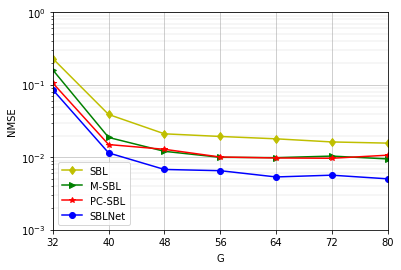

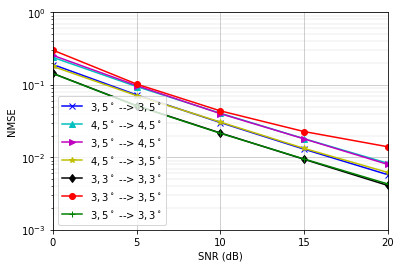

In [ ]:
[import numpy as np
from matplotlib import pyplot as plt

#%% impact of G
ax=plt.subplot(111)
ax.set_yscale('log')
plt.xlim([32,80])
plt.ylim([1e-3,1e0])
plt.xticks([32,40,48,56,64,72,80])
plt.yticks([1e-3,1e-2,1e-1,1e0])
plt.xlabel(r"$G$")
plt.ylabel("NMSE")

G_list = [32,40,48,56,64,72,80]

nmse_SBL_list = [0.2303,0.0390,0.0211,0.0194,0.0180,0.0163,0.0157]
nmse_M_SBL_list = [0.1606,0.0188,0.0121,0.0100,0.0099,0.0104,0.0095]
nmse_PC_SBL_list = [0.1058,0.0150,0.0129,0.0101,0.0098,0.0097,0.0107]
nmse_proposed_list = [0.0856,0.0115,0.0068,0.00654,0.00536,0.00567,0.00505]

plt.plot(G_list,nmse_SBL_list,'yd-')
plt.plot(G_list,nmse_M_SBL_list,'g>-')
plt.plot(G_list,nmse_PC_SBL_list,'r*-')
plt.plot(G_list,nmse_proposed_list,'bo-')


legends = ['SBL','M-SBL','PC-SBL','SBLNet']
plt.legend(legends,loc='lower left')
plt.grid()
ax.xaxis.grid(True, which='minor',linewidth=0.2)
ax.xaxis.grid(True, which='major',linewidth=0.6)
ax.yaxis.grid(True, which='minor',linewidth=0.2)
ax.yaxis.grid(True, which='major',linewidth=0.6)
# plt.savefig('./results/impact_of_G.eps')
plt.show()


#%% generalization to the number of clusters
ax=plt.subplot(111)
ax.set_yscale('log')
plt.xlim([0,20])
plt.ylim([1e-3,1e0])
plt.xticks([0,5,10,15,20])
plt.yticks([1e-3,1e-2,1e-1,1e0])
plt.xlabel("SNR (dB)")
plt.ylabel("NMSE")

SNR_list = [0,5,10,15,20]

# cluster number generalization
nmse_accurate_3clusters_AS5_list = [0.19081,0.07270,0.03020,0.01297,0.00577]
nmse_accurate_4clusters_AS5_list = [0.2395,0.0948,0.0406,0.0181,0.0083]
nmse_35_45_list = [0.2552,0.0979,0.0401,0.0180,0.0080]
nmse_45_35_list = [0.1798,0.0711,0.0307,0.0133,0.0062]

plt.plot(SNR_list,nmse_accurate_3clusters_AS5_list,'bx-')
plt.plot(SNR_list,nmse_accurate_4clusters_AS5_list,'c^-')
plt.plot(SNR_list,nmse_35_45_list,'m>-')
plt.plot(SNR_list,nmse_45_35_list,'y*-')

# AS generalization
nmse_accurate_3clusters_AS3_list = [0.1440,0.0517,0.0217,0.0094,0.0041] # actually it's worse
nmse_33_35_list = [0.3014,0.1026,0.0438,0.0227,0.0140]
nmse_35_33_list = [0.1433,0.0513,0.0215,0.0095,0.0043]
plt.plot(SNR_list,nmse_accurate_3clusters_AS3_list,'kd-')
plt.plot(SNR_list,nmse_33_35_list,'ro-')
plt.plot(SNR_list,nmse_35_33_list,'g+-')


legends = [r'$3,5^\circ$ --> $3,5^\circ$',r'$4,5^\circ$ --> $4,5^\circ$',r'$3,5^\circ$ --> $4,5^\circ$',r'$4,5^\circ$ --> $3,5^\circ$',r'$3,3^\circ$ --> $3,3^\circ$',r'$3,3^\circ$ --> $3,5^\circ$',r'$3,5^\circ$ --> $3,3^\circ$']
plt.legend(legends)
#legend = ax.legend(legends)
#frame = legend.get_frame()
#frame.set_alpha(1)
#frame.set_facecolor('none') # 设置图例legend背景透明
plt.grid()
ax.xaxis.grid(True, which='minor',linewidth=0.2)
ax.xaxis.grid(True, which='major',linewidth=0.6)
ax.yaxis.grid(True, which='minor',linewidth=0.2)
ax.yaxis.grid(True, which='major',linewidth=0.6)
# plt.savefig('./results/channel_generalization.eps')
plt.show()